<a href="https://colab.research.google.com/github/A00785001/TC5035/blob/main/002-Feat_Eng-LiDAR_Branch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LiDAR Preprocessing for Deep Learning
Preprocess LiDAR scans for feature extraction



## **Purpose of This Notebook**

This notebook serves as a **critical bridge** between raw ROS bag data and deep learning feature extraction. It performs two main functions:

1. **ROS Bag Analysis**
   - Basic Exploratory Data Analysis (EDA) of ROS topics
   - Message frequency and timing analysis
   - Data quality assessment

2. **LiDAR Preprocessing**
   - Extract raw LiDAR scans from `/scan` topic
   - Clean invalid readings (inf, nan, outliers)
   - Resample from 1147 points → 360 uniform points
   - Normalize to [0, 1] range
   - Save in format required by deep learning notebook

---

## **Integration with Deep Learning Pipeline**

### **Workflow:**
```

 THIS NOTEBOOK (002-Feat_Eng-LiDAR_Branch.ipynb)              
                                                                 
 Input:  session_data.bag                                       
         /scan topic (RPLIDAR A1 data)                      
                                                                 
 Process: 1. Analyze ROS bag structure                         
          2. Extract LaserScan messages                        
          3. Clean invalid readings                            
          4. Resample to 360 uniform points                    
          5. Normalize to [0, 1]                               
                                                                 
 Output: processed_lidar/                                      
         scan_0000000.csv  (360 normalized values)         
         scan_0000001.csv                                  
         ...                                                
         metadata.csv (timestamps, filenames)              

                              

 NEXT NOTEBOOK (the next phase)                
                                                                 
 Input:  processed_lidar/                                       
         scan_*.csv (360 points each)                      
         metadata.csv                                       
                                                                 
 Process: 1. Load preprocessed scans                           
          2. Pass through 1D CNN (360 → 256D features)         
          3. L2 normalize features                             
          4. Save to HDF5                                      
                                                                 
 Output: features.h5                                           
         lidar/features [N, 256]                           

```

---

## **Hardware Specifications: RPLIDAR A1**

### **Sensor Details:**
- **Model:** SLAMTEC RPLIDAR A1M8
- **Type:** 360° 2D Laser Scanner (Time-of-Flight)
- **Range:** 0.15m - 12.0m (typical 6m for older models)
- **Angular Coverage:** Full 360° (-180° to +180°)
- **Sample Rate:** 8000 samples/second
- **Scan Rate:** 5.5 Hz (typical), configurable 1-10 Hz
- **Points per Scan:** Variable (360-1450)

### **The Specific Configuration:**
Based on inspection of the ROS bag:
- **Points per scan:** 1147
- **Angular resolution:** 0.314° per point
- **Angular range:** -180° to +180° (full 360°)
- **Valid data rate:** ~76.5% (270 invalid 'inf' readings per scan)
- **Actual scan rate:** ~7.5 Hz (0.134 sec per scan)

---

## **ROS LaserScan Message Structure**

```python
sensor_msgs/LaserScan:
  header:
    seq: 1610                        # Message sequence number
    stamp: 1760649849.759624225      # ROS timestamp (sec.nsec)
    frame_id: 'laser_frame'          # Coordinate frame
  
  angle_min: -3.141593 rad           # Start angle (-180°)
  angle_max: 3.141593 rad            # End angle (+180°)
  angle_increment: 0.005483 rad      # Angular step (0.314°)
  
  time_increment: 0.000117 sec       # Time between measurements
  scan_time: 0.134082 sec            # Time for complete scan
  
  range_min: 0.150 m                 # Minimum valid range
  range_max: 12.000 m                # Maximum valid range
  
  ranges: [1147 values]              # Distance measurements (meters)
                                      # inf = no obstacle detected
  
  intensities: [1147 values]         # Reflectivity (0-47)
```

---

## **Preprocessing Pipeline Details**

### **Step 1: Extract Raw Data**
```python
# From ROS bag
ranges = msg.ranges              # numpy array, shape (1147,)
timestamp = msg.header.stamp     # ROS time
```

### **Step 2: Clean Invalid Readings**
```python
# Handle inf (no obstacle detected)
ranges[ranges == np.inf] = 12.0      # Replace with max_range

# Handle nan (sensor error)
ranges[np.isnan(ranges)] = 12.0

# Handle out-of-range values
ranges[ranges < 0.15] = 0.15         # Clip to min_range
ranges[ranges > 12.0] = 12.0         # Clip to max_range
```

**Why replace inf with 12.0?**
- `inf` means "no obstacle detected within max range"
- Physical meaning: "nothing detected up to 12 meters"
- Preserves semantic information for neural network

### **Step 3: Resample to 360 Points**

**Method: Angular Interpolation**
```python
# Original: 1147 irregularly spaced points
original_angles = np.linspace(-180, 180, 1147)  # degrees
original_ranges = cleaned_ranges                 # meters

# Target: 360 uniformly spaced points (1° resolution)
target_angles = np.linspace(-180, 180, 360)

# Linear interpolation
from scipy.interpolate import interp1d
f = interp1d(original_angles, original_ranges, kind='linear')
resampled_ranges = f(target_angles)
```

**Why 360 points?**
- CNN expects fixed input size
- 360 = 1° angular resolution (intuitive)
- Balance between detail and computational cost
- Standard in robotics (one reading per degree)

**Why linear interpolation?**
- Most accurate for distance measurements
- Preserves sharp edges (walls, corners)
- No smoothing/blurring effects
- Computationally efficient

### **Step 4: Normalize to [0, 1]**
```python
# Min-Max normalization
normalized = (resampled_ranges - 0.15) / (12.0 - 0.15)

# Result: [0, 1] range
# 0.0 = 0.15m (minimum sensor range)
# 1.0 = 12.0m (maximum sensor range)
```

**Why normalize to [0, 1]?**
- Deep learning networks expect normalized inputs
- Prevents numerical instability during training
- Standard practice for neural networks
- Required by second notebook's CNN architecture

### **Step 5: Save as CSV**
```python
# Save each scan as single-row CSV (no header)
np.savetxt('scan_0000000.csv', normalized.reshape(1, -1),
           delimiter=',', fmt='%.6f')

# Result: One line with 360 comma-separated values
# Example: 0.234567,0.456789,0.891234,...,0.123456
```

**Why CSV instead of NPY?**
- Required by second notebook (uses pd.read_csv)
- Human-readable for debugging
- Easy to inspect in spreadsheet software
- Trade-off: slower I/O, but acceptable for dataset size

---

## **Output Directory Structure**

```
processed_lidar/

scan_0000000.csv        # First scan (360 normalized values)
scan_0000001.csv        # Second scan
scan_0000002.csv        # Third scan
...
scan_NNNNNNN.csv        # Last scan

metadata.csv            # Scan metadata (REQUIRED by next notebook)
  Columns:
  - filename: e.g., "scan_0000000.csv"
  - timestamp: float (ROS time in seconds)
  - scan_id: integer index
  - original_points: 1147 (before resampling)
  - valid_points: count of non-inf readings
  - mean_range: average distance (for QA)

preprocessing_info.json # Processing parameters (for reproducibility)
    {
      "source_bag": "session_data.bag",
      "topic": "/scan",
      "sensor": "RPLIDAR A1",
      "original_points": 1147,
      "resampled_points": 360,
      "range_min": 0.15,
      "range_max": 12.0,
      "normalization": "min-max to [0,1]",
      "invalid_handling": "inf->max_range",
      "resampling_method": "linear_interpolation",
      "total_scans": "N",
      "processing_date": "2025-11-02"
    }
```

---

##  **Quality Assurance Checks**

After preprocessing, the notebook performs these validations:

1. **Shape Verification**
   - All CSV files have exactly 360 values
   - No missing or extra values

2. **Value Range**
   - All values in [0.0, 1.0]
   - No inf, nan, or negative values

3. **Temporal Continuity**
   - Timestamps strictly increasing
   - No large gaps (>0.5 sec)
   - Consistent scan rate

4. **Statistical Sanity**
   - Mean range: 3-8m (typical indoor)
   - Standard deviation reasonable
   - Not all constant values

5. **Visual Inspection**
   - Polar plots of sample scans
   - Before/after comparison (1147 vs 360)
   - Distribution histograms

---

## **Technical Background: Why This Matters**

### **Loop Closure Detection Pipeline:**
This preprocessing is part of a larger system for robot localization:

1. **Sensor Fusion:**
   - Camera images → MobileNet V2 → 1280D visual features
   - LiDAR scans → 1D CNN → 256D geometric features
   - Combined for robust place recognition

2. **Loop Closure:**
   - Detect when robot returns to previously visited location
   - Critical for SLAM (Simultaneous Localization and Mapping)
   - Corrects accumulated drift in odometry

3. **Why Deep Learning:**
   - Traditional methods (ICP, scan matching) struggle with:
     - Symmetrical environments
     - Dynamic objects
     - Viewpoint changes
   - Deep features capture semantic and geometric patterns
   - More robust to partial views and occlusions

---

## **Critical Notes**

### **Format Requirements:**
**The second notebook is VERY SPECIFIC about format:**
- Must be CSV files (not NPY)
- Must be single-row (no header)
- Must have exactly 360 values
- Must be normalized to [0, 1]
- Metadata.csv must have 'filename' and 'timestamp' columns

**Any deviation will cause the next notebook to fail!**

### **Coordinate Frames:**
- LaserScan angles: counterclockwise from forward (x-axis)
- 0° = robot forward
- 90° = robot left
- -90° = robot right
- 180° / -180° = robot backward

### **Timestamp Synchronization:**
- Timestamps preserved for future camera-LiDAR alignment
- Alignment happens AFTER feature extraction (in third notebook)
- Critical for sensor fusion

---

## **References & Resources**

**Hardware:**
- RPLIDAR A1 Datasheet: https://www.slamtec.com/en/Lidar/A1
- Waveshare JetBot: https://www.waveshare.com/wiki/JetBot_ROS_AI_Kit

**ROS Messages:**
- sensor_msgs/LaserScan: http://docs.ros.org/en/noetic/api/sensor_msgs/html/msg/LaserScan.html

**Related Work:**
- SegMatch: Segment based place recognition
- PointNetVLAD: Deep learning for LiDAR place recognition
- OverlapNet: Loop closure detection using range images

---

## **Expected Runtime**

For a typical session (~300 scans):
- ROS Bag EDA: ~30 seconds
- LiDAR Extraction: ~1-2 minutes
- Total preprocessing: ~2-3 minutes
- Output size: ~500 KB

---

## <font color='#2E86AB'>1. Initialization and Setup</font>

In [1]:
# Install required packages
!pip install --quiet rosbags opencv-python pillow numpy matplotlib tqdm seaborn pandas scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.1/753.1 kB 17.2 MB/s eta 0:00:00


In [2]:
# Import libraries - Core
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
from datetime import datetime
from tqdm import tqdm
from collections import defaultdict
import io

# Import scipy for interpolation (LiDAR resampling)
from scipy.interpolate import interp1d

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [3]:
from rosbags.rosbag1 import Reader
from rosbags.typesys import Stores, get_typestore
import os
from pathlib import Path
print("Libraries loaded successfully!")

Libraries loaded successfully!


In [4]:
# Initialize typestore for ROS1 message deserialization
typestore = get_typestore(Stores.ROS1_NOETIC)
print("Typestore initialized for ROS1")

Typestore initialized for ROS1


## <font color='#2E86AB'>2. Storage Mounting</font>

In [5]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## <font color='#2E86AB'>3. ROS Bag Load</font>

In [6]:
# Specify the path to the sessions folder
data_path = "/content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/"

In [7]:
# Specify the session
#session = '20251016_133216'
session = '20251022_155137'
print(f"Using session: {session}")

Using session: 20251022_155137


In [8]:
# Construct paths
bag_path = Path(data_path) / f"session_{session}" / "session_data.bag"
bag_name = "session_data.bag"

if not bag_path.exists():
    print(f"❌ Bag file not found: {bag_path}")
else:
    print(f"✓ Found bag file: {bag_path}")
    file_size_mb = bag_path.stat().st_size / (1024 * 1024)
    print(f"  Size: {file_size_mb:.2f} MB")

✓ Found bag file: /content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/session_20251022_155137/session_data.bag
  Size: 583.74 MB


## <font color='#2E86AB'>4. Basic EDA - Exploratory Data Analysis</font>

### 1. Bag Info & Topics Analysis

In [9]:
# Open bag and get basic info
print("=" * 60)
print("ROS BAG BASIC INFORMATION")
print("=" * 60)

with Reader(bag_path) as reader:
    # Get bag duration
    duration_ns = reader.duration
    duration_sec = duration_ns / 1e9

    # Get start and end times
    start_time = reader.start_time / 1e9
    end_time = reader.end_time / 1e9

    print(f"\nFile: {bag_name}")
    print(f"   Size: {file_size_mb:.2f} MB")
    print(f"   Duration: {duration_sec:.2f} seconds ({duration_sec/60:.2f} minutes)")
    print(f"   Start time: {datetime.fromtimestamp(start_time)}")
    print(f"   End time: {datetime.fromtimestamp(end_time)}")

    # Message statistics
    total_messages = reader.message_count
    unique_topics = set(conn.topic for conn in reader.connections)

    print(f"\nMessages:")
    print(f"   Total: {total_messages:,}")
    print(f"   Topics: {len(unique_topics)}")
    print(f"   Average rate: {total_messages/duration_sec:.2f} msg/sec")

    avg_message_rate = total_messages / duration_sec

ROS BAG BASIC INFORMATION

File: session_data.bag
   Size: 583.74 MB
   Duration: 394.36 seconds (6.57 minutes)
   Start time: 2025-10-22 23:26:13.225766
   End time: 2025-10-22 23:32:47.590153

Messages:
   Total: 158,044
   Topics: 10
   Average rate: 400.76 msg/sec


In [10]:
# Analyze connections (topics)
print("=" * 60)
print("TOPIC CONNECTIONS ANALYSIS")
print("=" * 60)

with Reader(bag_path) as reader:
    # Build connections info
    connections_info = []

    for idx, conn in enumerate(reader.connections):
        connections_info.append({
            'Connection_Index': idx,
            'Topic': conn.topic,
            'Message Type': conn.msgtype,
            'Message Count': conn.msgcount,
            'Description': ''
        })

    df_topics = pd.DataFrame(connections_info)

    # Add descriptions
    topic_descriptions = {
        '/csi_cam_0/image_raw/compressed': '',
        '/csi_cam_0/camera_info': '',
        '/imu': '',
        '/scan': '',
        '/odom': '',
        '/cmd_vel': '',
        '/tf': '',
        '/submap_list': '',
        '/constraint_list': '',
        '/trajectory_node_list': ''
    }

    # Group by topic for multi-connection topics like /tf
    tf_topics = df_topics[df_topics['Topic'] == '/tf']
    if len(tf_topics) > 1:
        for idx, row in tf_topics.iterrows():
            if row['Connection_Index'] == 3:
                df_topics.at[idx, 'Description'] = 'SLAM: map→odom, odom→base_footprint'
            elif row['Connection_Index'] == 4:
                df_topics.at[idx, 'Description'] = 'Static: base_footprint→laser_frame'
            elif row['Connection_Index'] == 5:
                df_topics.at[idx, 'Description'] = 'Static: base_footprint→base_imu_link'
            elif row['Connection_Index'] == 7:
                df_topics.at[idx, 'Description'] = 'Odometry: odom→base_footprint'

    print("\nTopics Overview:")
    print(df_topics.to_string(index=False))

    # Calculate frequencies
    print("\nMessage Frequencies:")
    print(f"{'Topic':<40} {'Count':<10} {'Hz':<10}")
    print("-" * 60)

    for _, row in df_topics.iterrows():
        freq = row['Message Count'] / duration_sec
        print(f"{row['Topic']:<40} {row['Message Count']:<10} {freq:<10.2f}")

TOPIC CONNECTIONS ANALYSIS

Topics Overview:
 Connection_Index                           Topic                         Message Type  Message Count                   Description
                0                /constraint_list   visualization_msgs/msg/MarkerArray            589                              
                1          /csi_cam_0/camera_info           sensor_msgs/msg/CameraInfo           7047                              
                2 /csi_cam_0/image_raw/compressed      sensor_msgs/msg/CompressedImage           7193                              
                3                            /imu                  sensor_msgs/msg/Imu          18736                              
                4                           /odom                nav_msgs/msg/Odometry           8431                              
                5                           /scan            sensor_msgs/msg/LaserScan           2973                              
                6              

### 2. Sample Message Display

In [11]:
# Display sample messages from each topic
print("=" * 60)
print("SAMPLE RAW MESSAGE")
print("=" * 60)

# Choose which topic to display (change as needed)
display_topic = '/scan'

with Reader(bag_path) as reader:
    for connection, timestamp, rawdata in reader.messages():
        if connection.topic == display_topic:
            print(f"\nDisplaying sample message from: {connection.topic}")
            print(f"   Message Type: {connection.msgtype}")
            print(f"   Timestamp: {timestamp / 1e9:.6f} seconds")

            # Try to deserialize message with error handling
            try:
                msg = typestore.deserialize_ros1(rawdata, connection.msgtype)

                if display_topic == '/scan':
                    print(f"\n   Message Structure:")
                    print("-" * 60)
                    print(f"   Header:")
                    print(f"     seq: {msg.header.seq}")
                    print(f"     stamp: {msg.header.stamp.sec}.{msg.header.stamp.nanosec:09d}")
                    try:
                        print(f"     frame_id: '{msg.header.frame_id}'")
                    except:
                        print(f"     frame_id: [binary data - cannot display]")

                    print(f"\n   Scan Parameters:")
                    print(f"     angle_min: {msg.angle_min:.6f} rad ({np.degrees(msg.angle_min):.2f}°)")
                    print(f"     angle_max: {msg.angle_max:.6f} rad ({np.degrees(msg.angle_max):.2f}°)")
                    print(f"     angle_increment: {msg.angle_increment:.6f} rad ({np.degrees(msg.angle_increment):.4f}°)")
                    print(f"     time_increment: {msg.time_increment:.6f} seconds")
                    print(f"     scan_time: {msg.scan_time:.6f} seconds")
                    print(f"     range_min: {msg.range_min:.3f} m")
                    print(f"     range_max: {msg.range_max:.3f} m")

                    ranges_array = np.array(msg.ranges)
                    intensities_array = np.array(msg.intensities)

                    print(f"\n   Range Data:")
                    print(f"     Total points: {len(ranges_array)}")
                    print(f"     First 10 ranges: {ranges_array[:10]}")
                    print(f"     Last 10 ranges: {ranges_array[-10:]}")
                    valid_ranges = np.isfinite(ranges_array)
                    print(f"     Valid ranges: {np.sum(valid_ranges)} ({100*np.sum(valid_ranges)/len(ranges_array):.1f}%)")

                    print(f"\n   Intensity Data:")
                    print(f"     Total points: {len(intensities_array)}")
                    print(f"     First 10 intensities: {intensities_array[:10]}")
                    print(f"     Min: {np.min(intensities_array):.2f}, Max: {np.max(intensities_array):.2f}, Mean: {np.mean(intensities_array):.2f}")

            except UnicodeDecodeError as e:
                print(f"\n Warning: Unable to fully deserialize message due to encoding issue.")
                print(f"   Error: {str(e)}")
                print(f"\n   This is a common issue with some ROS bags and won't affect preprocessing.")
                print(f"   Message data:")
                print(f"     Topic: {connection.topic}")
                print(f"     Type: {connection.msgtype}")
                print(f"     Raw data size: {len(rawdata)} bytes")
                print(f"\n   ✓ The LiDAR preprocessing section will handle this correctly.")
            except Exception as e:
                print(f"\n Warning: Unable to deserialize message.")
                print(f"   Error: {type(e).__name__}: {str(e)}")
                print(f"\n   ✓ The LiDAR preprocessing section will handle this correctly.")

            break  # Only show first message

SAMPLE RAW MESSAGE

Displaying sample message from: /scan
   Message Type: sensor_msgs/msg/LaserScan
   Timestamp: 1761175573.226155 seconds

   Message Structure:
------------------------------------------------------------
   Header:
     seq: 1278
     stamp: 1761175571.685149040
     frame_id: 'laser_frame'

   Scan Parameters:
     angle_min: -3.141593 rad (-180.00°)
     angle_max: 3.141593 rad (180.00°)
     angle_increment: 0.005483 rad (0.3141°)
     time_increment: 0.000118 seconds
     scan_time: 0.134759 seconds
     range_min: 0.150 m
     range_max: 12.000 m

   Range Data:
     Total points: 1147
     First 10 ranges: [12.096 12.096 12.096 12.096 12.056    inf    inf    inf    inf    inf]
     Last 10 ranges: [inf inf inf inf inf inf inf inf inf inf]
     Valid ranges: 834 (72.7%)

   Intensity Data:
     Total points: 1147
     First 10 intensities: [47. 47. 47. 47. 47.  0.  0.  0.  0.  0.]
     Min: 0.00, Max: 47.00, Mean: 34.17


### 3. Timing Analysis

In [12]:
# Analyze message timing
print("=" * 60)
print("TIMING ANALYSIS")
print("=" * 60)

with Reader(bag_path) as reader:
    connection_timestamps = defaultdict(list)

    print("\nCollecting timestamps...")
    for connection, timestamp, rawdata in tqdm(reader.messages(), total=reader.message_count):
        # Find connection index
        conn_idx = None
        for idx, conn in enumerate(reader.connections):
            if (conn.topic == connection.topic and
                conn.msgtype == connection.msgtype and
                conn.msgcount == connection.msgcount):
                conn_idx = idx
                break

        if conn_idx is not None:
            connection_timestamps[conn_idx].append(timestamp / 1e9)

    # Calculate intervals
    print("\nMessage Intervals (time between messages):")
    print(f"{'Topic':<40} {'Description':<30} {'Mean (ms)':<12} {'Std (ms)':<12}")
    print("-" * 94)

    for conn_idx, timestamps in sorted(connection_timestamps.items()):
        if len(timestamps) > 1:
            intervals = np.diff(timestamps) * 1000  # Convert to ms

            # Get topic info from df_topics
            topic_row = df_topics[df_topics['Connection_Index'] == conn_idx].iloc[0]
            topic_name = topic_row['Topic']
            description = topic_row['Description'][:28] if topic_row['Description'] else ''

            print(f"{topic_name:<40} {description:<30} {np.mean(intervals):<12.2f} {np.std(intervals):<12.2f}")

TIMING ANALYSIS



100%|██████████| 158044/158044 [00:04<00:00, 37582.62it/s]


Message Intervals (time between messages):
Topic                                    Description                    Mean (ms)    Std (ms)    
----------------------------------------------------------------------------------------------
/constraint_list                                                        521.80       297.90      
/csi_cam_0/camera_info                                                  55.93        470.38      
/csi_cam_0/image_raw/compressed                                         54.83        254.16      
/imu                                                                    21.05        157.68      
/odom                                                                   46.78        366.00      
/scan                                                                   132.64       564.50      
/submap_list                                                            339.06       1134.91     
/tf                                      Odometry: odom→base_footprin   8.42 

### 4. Message Size Distribution Analysis

In [13]:
# Analyze message sizes per connection
print("=" * 60)
print("MESSAGE SIZE ANALYSIS")
print("=" * 60)

with Reader(bag_path) as reader:
    connection_sizes = defaultdict(list)

    print("\nCollecting message sizes...")
    for connection, timestamp, rawdata in tqdm(reader.messages(), total=reader.message_count):
        # Find connection index
        conn_idx = None
        for idx, conn in enumerate(reader.connections):
            if (conn.topic == connection.topic and
                conn.msgtype == connection.msgtype and
                conn.msgcount == connection.msgcount):
                conn_idx = idx
                break

        if conn_idx is not None:
            connection_sizes[conn_idx].append(len(rawdata))

    # Calculate statistics
    size_stats = []
    for conn_idx, sizes in connection_sizes.items():
        sizes_array = np.array(sizes)
        topic_row = df_topics[df_topics['Connection_Index'] == conn_idx].iloc[0]

        size_stats.append({
            'Topic': topic_row['Topic'],
            'Description': topic_row['Description'][:40] if topic_row['Description'] else '',
            'Avg Size (bytes)': np.mean(sizes_array),
            'Total Size (MB)': np.sum(sizes_array) / (1024 * 1024)
        })

    df_sizes = pd.DataFrame(size_stats)
    df_sizes = df_sizes.sort_values('Total Size (MB)', ascending=False)

    print("\nMessage Size Statistics:")
    print(df_sizes.to_string(index=False))

    df_sizes.to_csv('message_size_statistics.csv', index=False)

MESSAGE SIZE ANALYSIS



100%|██████████| 158044/158044 [00:04<00:00, 36277.10it/s]



Message Size Statistics:
                          Topic                   Description  Avg Size (bytes)  Total Size (MB)
/csi_cam_0/image_raw/compressed                                    32197.801891       220.869817
          /trajectory_node_list                                    16362.123393       171.099360
               /constraint_list                                   227311.572156       127.684132
                          /scan                                     9239.000000        26.195094
                            /tf Odometry: odom→base_footprint        181.000000         8.079593
                           /imu                                      325.000000         5.807114
                          /odom                                      719.000000         5.781068
         /csi_cam_0/camera_info                                      361.000000         2.426116
                            /tf                                      107.000000         1.776367
    

In [14]:
# Generate ROS Bag Basic EDA summary report
print("=" * 60)
print("ROS BAG BASIC EDA - SUMMARY REPORT")
print("=" * 60)

rosbag_summary = f"""
ROS BAG BASIC EDA SUMMARY
{'='*60}

FILE INFORMATION:
  File: {bag_name}
  Size: {file_size_mb:.2f} MB
  Duration: {duration_sec:.2f} seconds ({duration_sec/60:.2f} minutes)

MESSAGE STATISTICS:
  Total Messages: {total_messages:,}
  Unique Topics: {len(unique_topics)}
  Message Types: {df_topics['Message Type'].nunique()}
  Average Rate: {avg_message_rate:.2f} msg/sec

DATA QUALITY:
  Average Data Rate: {file_size_mb / (duration_sec/60):.2f} MB/min

TOP 3 TOPICS BY SIZE:
"""

for idx, row in df_sizes.head(3).iterrows():
    rosbag_summary += f"  {idx+1}. {row['Topic']}: {row['Total Size (MB)']:.2f} MB\n"

print(rosbag_summary)

# Save report
with open('rosbag_basic_eda_summary.txt', 'w') as f:
    f.write(rosbag_summary)

print("\n✅ ROS Bag Basic EDA summary saved to: rosbag_basic_eda_summary.txt")

ROS BAG BASIC EDA - SUMMARY REPORT

ROS BAG BASIC EDA SUMMARY

FILE INFORMATION:
  File: session_data.bag
  Size: 583.74 MB
  Duration: 394.36 seconds (6.57 minutes)

MESSAGE STATISTICS:
  Total Messages: 158,044
  Unique Topics: 10
  Message Types: 9
  Average Rate: 400.76 msg/sec

DATA QUALITY:
  Average Data Rate: 88.81 MB/min

TOP 3 TOPICS BY SIZE:
  3. /csi_cam_0/image_raw/compressed: 220.87 MB
  12. /trajectory_node_list: 171.10 MB
  1. /constraint_list: 127.68 MB


✅ ROS Bag Basic EDA summary saved to: rosbag_basic_eda_summary.txt



---
# LiDAR Data Extraction & Preprocessing
---

## <font color='#FF6B35'>5. LiDAR Preprocessing Configuration</font>

In [15]:
# Configuration parameters for LiDAR preprocessing
print("=" * 60)
print("LIDAR PREPROCESSING CONFIGURATION")
print("=" * 60)

# Output directory
# Output directory - create at same level as bag file
bag_dir = os.path.dirname(bag_path)
LIDAR_OUTPUT_DIR = os.path.join(bag_dir, "processed_lidar")

# Processing parameters (from RPLIDAR A1 specifications)
LIDAR_CONFIG = {
    'range_min': 0.15,          # Minimum valid range (meters)
    'range_max': 12.0,          # Maximum valid range (meters)
    'target_points': 360,       # Resample to 360 uniform points
    'angular_range': (-180, 180),  # Full 360° coverage
    'normalize': True,          # Normalize to [0, 1]
    'invalid_strategy': 'max_range'  # Replace inf with max_range
}

print(f"\nOutput directory: {LIDAR_OUTPUT_DIR}")
print(f"\n Processing Parameters:")
for key, value in LIDAR_CONFIG.items():
    print(f"   {key}: {value}")

# Create output directory
os.makedirs(LIDAR_OUTPUT_DIR, exist_ok=True)
print(f"\n✓ Output directory created: {LIDAR_OUTPUT_DIR}")

LIDAR PREPROCESSING CONFIGURATION

Output directory: /content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/session_20251022_155137/processed_lidar

 Processing Parameters:
   range_min: 0.15
   range_max: 12.0
   target_points: 360
   angular_range: (-180, 180)
   normalize: True
   invalid_strategy: max_range

✓ Output directory created: /content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/session_20251022_155137/processed_lidar


## <font color='#FF6B35'>6. Extract & Preprocess LiDAR Scans</font>

In [16]:
def clean_lidar_scan(ranges, range_min=0.15, range_max=12.0):
    """
    Clean invalid readings from LiDAR scan.

    Args:
        ranges: numpy array of range values
        range_min: minimum valid range
        range_max: maximum valid range

    Returns:
        cleaned ranges array
    """
    cleaned = np.array(ranges, dtype=np.float32)

    # Replace inf with max_range (no obstacle detected)
    cleaned[np.isinf(cleaned)] = range_max

    # Replace nan with max_range (sensor error)
    cleaned[np.isnan(cleaned)] = range_max

    # Clip to valid range
    cleaned = np.clip(cleaned, range_min, range_max)

    return cleaned


def resample_lidar_scan(ranges, original_points, target_points=360):
    """
    Resample LiDAR scan to uniform angular resolution.

    Args:
        ranges: cleaned range values (original_points,)
        original_points: number of points in original scan
        target_points: desired number of uniform points

    Returns:
        resampled ranges array (target_points,)
    """
    # Create angular grids
    original_angles = np.linspace(-180, 180, original_points)
    target_angles = np.linspace(-180, 180, target_points)

    # Linear interpolation
    interpolator = interp1d(original_angles, ranges, kind='linear',
                           bounds_error=False, fill_value='extrapolate')
    resampled = interpolator(target_angles)

    return resampled.astype(np.float32)


def normalize_lidar_scan(ranges, range_min=0.15, range_max=12.0):
    """
    Normalize range values to [0, 1].

    Args:
        ranges: range values in meters
        range_min: minimum range for normalization
        range_max: maximum range for normalization

    Returns:
        normalized ranges in [0, 1]
    """
    normalized = (ranges - range_min) / (range_max - range_min)
    return np.clip(normalized, 0.0, 1.0).astype(np.float32)


print("✓ LiDAR preprocessing functions defined")

✓ LiDAR preprocessing functions defined


In [17]:
# Extract and preprocess all LiDAR scans
print("=" * 60)
print("EXTRACTING AND PREPROCESSING LIDAR SCANS")
print("=" * 60)

lidar_metadata = []
scan_count = 0
error_count = 0

print(f"\nProcessing scans from /scan topic...\n")

with Reader(bag_path) as reader:
    # Count total /scan messages for progress bar
    total_scans = sum(1 for conn in reader.connections if conn.topic == '/scan' for _ in range(conn.msgcount))

    with tqdm(total=total_scans, desc="Processing scans") as pbar:
        for connection, timestamp, rawdata in reader.messages():
            if connection.topic == '/scan':
                try:
                    # Deserialize LaserScan message
                    msg = typestore.deserialize_ros1(rawdata, connection.msgtype)

                    # Extract ranges
                    ranges = np.array(msg.ranges, dtype=np.float32)
                    original_points = len(ranges)

                    # Count valid points (before cleaning)
                    valid_points = np.sum(np.isfinite(ranges))

                    # Step 1: Clean invalid readings
                    cleaned_ranges = clean_lidar_scan(
                        ranges,
                        LIDAR_CONFIG['range_min'],
                        LIDAR_CONFIG['range_max']
                    )

                    # Step 2: Resample to 360 uniform points
                    resampled_ranges = resample_lidar_scan(
                        cleaned_ranges,
                        original_points,
                        LIDAR_CONFIG['target_points']
                    )

                    # Step 3: Normalize to [0, 1]
                    if LIDAR_CONFIG['normalize']:
                        normalized_ranges = normalize_lidar_scan(
                            resampled_ranges,
                            LIDAR_CONFIG['range_min'],
                            LIDAR_CONFIG['range_max']
                        )
                    else:
                        normalized_ranges = resampled_ranges

                    # Step 4: Save as single-row CSV (no header)
                    filename = f"scan_{scan_count:07d}.csv"
                    filepath = os.path.join(LIDAR_OUTPUT_DIR, filename)

                    np.savetxt(
                        filepath,
                        normalized_ranges.reshape(1, -1),
                        delimiter=',',
                        fmt='%.6f'
                    )

                    # Step 5: Store metadata
                    # Calculate mean range (in original meters, before normalization)
                    mean_range = np.mean(cleaned_ranges)

                    lidar_metadata.append({
                        'scan_id': scan_count,
                        'filename': filename,
                        'timestamp': timestamp / 1e9,  # Convert to seconds
                        'original_points': original_points,
                        'valid_points': int(valid_points),
                        'mean_range': float(mean_range),
                        'min_range': float(np.min(cleaned_ranges)),
                        'max_range': float(np.max(cleaned_ranges))
                    })

                    scan_count += 1

                except (UnicodeDecodeError, Exception) as e:
                    # Skip scans that fail to deserialize
                    error_count += 1
                    if error_count == 1:
                        print(f"\n Skipping {error_count} scan(s) with deserialization errors...")

                finally:
                    pbar.update(1)

if error_count > 0:
    print(f"\n Warning: Skipped {error_count} scans due to deserialization errors")
    print(f"   This is normal for some ROS bags with encoding issues")
    print(f"   Successfully processed: {scan_count} scans")

print(f"\n✓ Processed {scan_count} scans")
print(f"✓ Saved to: {LIDAR_OUTPUT_DIR}/")

EXTRACTING AND PREPROCESSING LIDAR SCANS

Processing scans from /scan topic...



Processing scans: 100%|██████████| 2973/2973 [01:02<00:00, 47.68it/s]


✓ Processed 2973 scans
✓ Saved to: /content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/session_20251022_155137/processed_lidar/


## <font color='#FF6B35'>7. Save Metadata & Processing Info</font>

In [18]:
# Save metadata.csv (REQUIRED by next notebook)
print("=" * 60)
print("SAVING METADATA")
print("=" * 60)

df_lidar_metadata = pd.DataFrame(lidar_metadata)
metadata_path = os.path.join(LIDAR_OUTPUT_DIR, 'metadata.csv')
df_lidar_metadata.to_csv(metadata_path, index=False)

print(f"\n✓ Metadata saved: {metadata_path}")
print(f"\nMetadata Preview:")
print(df_lidar_metadata.head(10))

print(f"\nStatistics:")
print(f"   Total scans: {len(df_lidar_metadata)}")
print(f"   Time range: {df_lidar_metadata['timestamp'].min():.2f} - {df_lidar_metadata['timestamp'].max():.2f} sec")
print(f"   Duration: {df_lidar_metadata['timestamp'].max() - df_lidar_metadata['timestamp'].min():.2f} sec")
print(f"   Average scan rate: {len(df_lidar_metadata) / (df_lidar_metadata['timestamp'].max() - df_lidar_metadata['timestamp'].min()):.2f} Hz")

SAVING METADATA

✓ Metadata saved: /content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/session_20251022_155137/processed_lidar/metadata.csv

Metadata Preview:
   scan_id          filename     timestamp  original_points  valid_points  \
0        0  scan_0000000.csv  1.761176e+09             1147           834   
1        1  scan_0000001.csv  1.761176e+09             1147           846   
2        2  scan_0000002.csv  1.761176e+09             1147           850   
3        3  scan_0000003.csv  1.761176e+09             1147           860   
4        4  scan_0000004.csv  1.761176e+09             1147           826   
5        5  scan_0000005.csv  1.761176e+09             1147           848   
6        6  scan_0000006.csv  1.761176e+09             1147           835   
7        7  scan_0000007.csv  1.761176e+09             1147           848   
8        8  scan_0000008.csv  1.761176e+09             1147           851   
9        9

In [19]:
# Save preprocessing_info.json (for reproducibility)
preprocessing_info = {
    'source_bag': str(bag_path),
    'topic': '/scan',
    'sensor': 'RPLIDAR A1',
    'original_points_per_scan': int(df_lidar_metadata['original_points'].iloc[0]),
    'resampled_points_per_scan': LIDAR_CONFIG['target_points'],
    'angular_range_deg': LIDAR_CONFIG['angular_range'],
    'angular_resolution_deg': 360.0 / LIDAR_CONFIG['target_points'],
    'range_min_m': LIDAR_CONFIG['range_min'],
    'range_max_m': LIDAR_CONFIG['range_max'],
    'normalization': 'min-max to [0,1]' if LIDAR_CONFIG['normalize'] else 'none',
    'invalid_handling': LIDAR_CONFIG['invalid_strategy'],
    'resampling_method': 'linear_interpolation',
    'total_scans': scan_count,
    'processing_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'bag_duration_sec': float(duration_sec),
    'average_scan_rate_hz': float(scan_count / duration_sec)
}

info_path = os.path.join(LIDAR_OUTPUT_DIR, 'preprocessing_info.json')
with open(info_path, 'w') as f:
    json.dump(preprocessing_info, f, indent=2)

print(f"✓ Processing info saved: {info_path}")
print(f"\nProcessing Configuration:")
print(json.dumps(preprocessing_info, indent=2))

✓ Processing info saved: /content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/session_20251022_155137/processed_lidar/preprocessing_info.json

Processing Configuration:
{
  "source_bag": "/content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/session_20251022_155137/session_data.bag",
  "topic": "/scan",
  "sensor": "RPLIDAR A1",
  "original_points_per_scan": 1147,
  "resampled_points_per_scan": 360,
  "angular_range_deg": [
    -180,
    180
  ],
  "angular_resolution_deg": 1.0,
  "range_min_m": 0.15,
  "range_max_m": 12.0,
  "normalization": "min-max to [0,1]",
  "invalid_handling": "max_range",
  "resampling_method": "linear_interpolation",
  "total_scans": 2973,
  "processing_date": "2025-11-06 03:43:55",
  "bag_duration_sec": 394.364387527,
  "average_scan_rate_hz": 7.538713164855573
}


## <font color='#FF6B35'>8. Quality Assurance & Validation</font>

In [20]:
# Validate output files
print("=" * 60)
print("QUALITY ASSURANCE CHECKS")
print("=" * 60)

print("\nValidating output files...\n")

# Check 1: File count
csv_files = [f for f in os.listdir(LIDAR_OUTPUT_DIR) if f.endswith('.csv') and f.startswith('scan_')]
print(f"✓ Check 1: File count")
print(f"   Expected: {scan_count} scans")
print(f"   Found: {len(csv_files)} CSV files")
print(f"   Status: {'PASS' if len(csv_files) == scan_count else 'FAIL'}")

# Check 2: File format and shape
print(f"\n✓ Check 2: File format and shape")
sample_files = np.random.choice(csv_files, min(5, len(csv_files)), replace=False)
all_valid = True

for filename in sample_files:
    filepath = os.path.join(LIDAR_OUTPUT_DIR, filename)
    data = pd.read_csv(filepath, header=None).values[0]

    is_valid = len(data) == 360
    all_valid = all_valid and is_valid

    print(f"   {filename}: shape={data.shape}, valid={is_valid}")

print(f"   Status: {'PASS' if all_valid else 'FAIL'}")

# Check 3: Value range
print(f"\n✓ Check 3: Value range [0, 1]")
all_in_range = True

for filename in sample_files:
    filepath = os.path.join(LIDAR_OUTPUT_DIR, filename)
    data = pd.read_csv(filepath, header=None).values[0]

    min_val, max_val = data.min(), data.max()
    has_invalid = np.any(np.isnan(data)) or np.any(np.isinf(data))
    in_range = (min_val >= 0.0) and (max_val <= 1.0) and not has_invalid
    all_in_range = all_in_range and in_range

    print(f"   {filename}: min={min_val:.4f}, max={max_val:.4f}, valid={in_range}")

print(f"   Status: {'PASS' if all_in_range else 'FAIL'}")

# Check 4: Temporal continuity
print(f"\n✓ Check 4: Temporal continuity")
timestamps = df_lidar_metadata['timestamp'].values
time_diffs = np.diff(timestamps)

is_monotonic = np.all(time_diffs > 0)
max_gap = np.max(time_diffs)
mean_interval = np.mean(time_diffs)

print(f"   Timestamps monotonic: {is_monotonic}")
print(f"   Mean interval: {mean_interval:.4f} sec ({1/mean_interval:.2f} Hz)")
print(f"   Max gap: {max_gap:.4f} sec")
print(f"   Status: {'PASS' if is_monotonic and max_gap < 0.5 else 'WARNING' if is_monotonic else 'FAIL'}")

# Check 5: Statistical sanity
print(f"\n✓ Check 5: Statistical sanity")
mean_ranges = df_lidar_metadata['mean_range'].values
overall_mean = np.mean(mean_ranges)
overall_std = np.std(mean_ranges)

is_sane = (overall_mean > 1.0) and (overall_mean < 10.0) and (overall_std > 0.1)

print(f"   Mean range: {overall_mean:.2f} m")
print(f"   Std range: {overall_std:.2f} m")
print(f"   Status: {'PASS' if is_sane else 'WARNING'}")

print(f"\n{'='*60}")
print(f"OVERALL STATUS: {'✓ ALL CHECKS PASSED' if all_valid and all_in_range and is_monotonic and is_sane else 'REVIEW WARNINGS'}")
print(f"{'='*60}")

QUALITY ASSURANCE CHECKS

Validating output files...

✓ Check 1: File count
   Expected: 2973 scans
   Found: 2973 CSV files
   Status: PASS

✓ Check 2: File format and shape
   scan_0002942.csv: shape=(360,), valid=True
   scan_0000597.csv: shape=(360,), valid=True
   scan_0001566.csv: shape=(360,), valid=True
   scan_0000017.csv: shape=(360,), valid=True
   scan_0002025.csv: shape=(360,), valid=True
   Status: PASS

✓ Check 3: Value range [0, 1]
   scan_0002942.csv: min=0.0317, max=1.0000, valid=True
   scan_0000597.csv: min=0.0500, max=1.0000, valid=True
   scan_0001566.csv: min=0.0469, max=1.0000, valid=True
   scan_0000017.csv: min=0.0424, max=1.0000, valid=True
   scan_0002025.csv: min=0.0334, max=1.0000, valid=True
   Status: PASS

✓ Check 4: Temporal continuity
   Timestamps monotonic: True
   Mean interval: 0.1326 sec (7.54 Hz)
   Max gap: 29.2624 sec
   Status: WARNING

✓ Check 5: Statistical sanity
   Mean range: 6.36 m
   Std range: 0.97 m
   Status: PASS

OVERALL STATUS: ✓

## <font color='#FF6B35'>9. Visualization</font>

VISUALIZATION


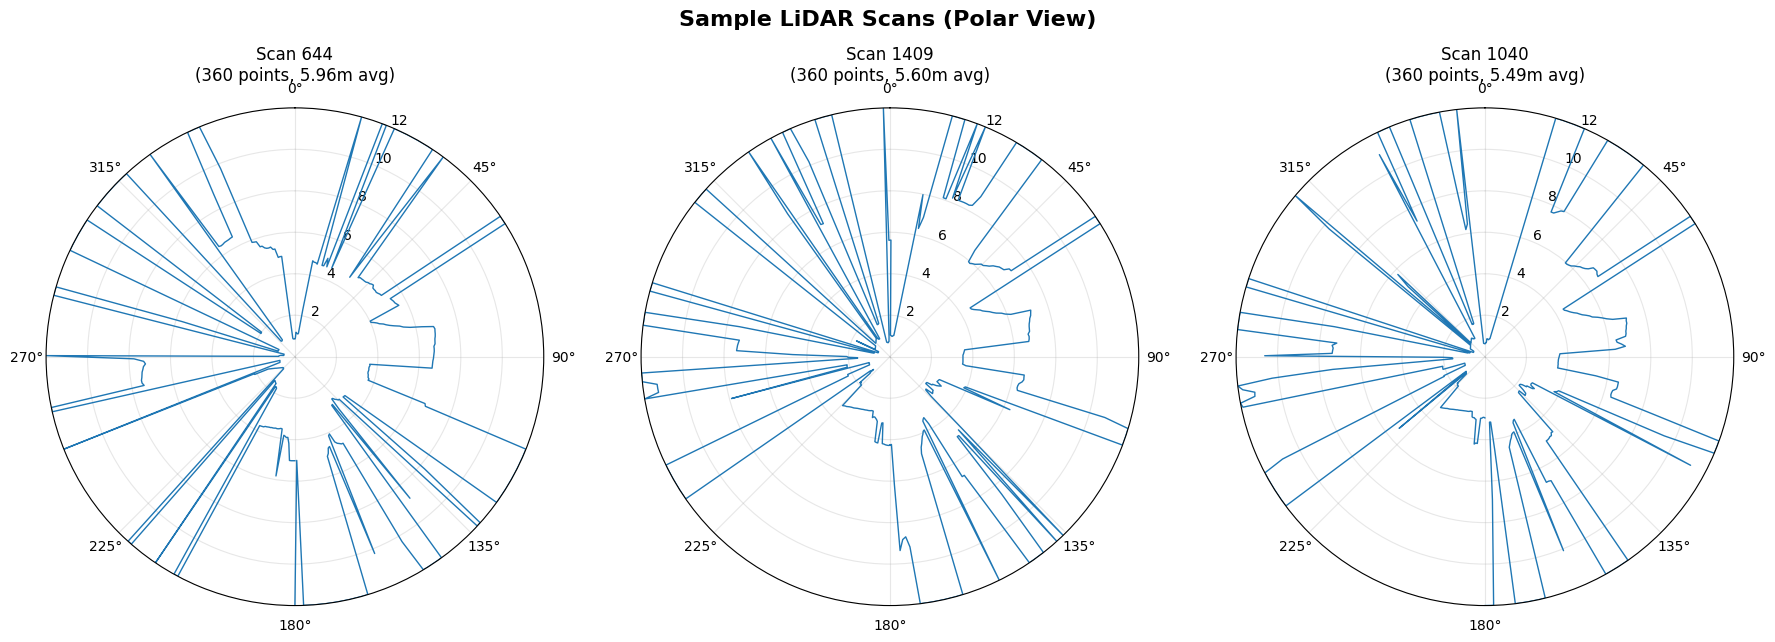


✓ Visualization saved: /content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/session_20251022_155137/processed_lidar/sample_scans_polar.png


In [21]:
# Visualize sample scans
print("=" * 60)
print("VISUALIZATION")
print("=" * 60)

# Select random scans for visualization
n_samples = min(3, len(csv_files))
sample_indices = np.random.choice(len(csv_files), n_samples, replace=False)

fig = plt.figure(figsize=(18, 6))

for i, idx in enumerate(sample_indices):
    filename = f"scan_{idx:07d}.csv"
    filepath = os.path.join(LIDAR_OUTPUT_DIR, filename)

    # Load normalized scan
    normalized_data = pd.read_csv(filepath, header=None).values[0]

    # Convert back to meters for visualization
    ranges_meters = normalized_data * (LIDAR_CONFIG['range_max'] - LIDAR_CONFIG['range_min']) + LIDAR_CONFIG['range_min']

    # Create polar plot
    ax = fig.add_subplot(1, n_samples, i+1, projection='polar')

    angles = np.linspace(-np.pi, np.pi, 360)
    ax.plot(angles, ranges_meters, linewidth=1)
    ax.set_ylim(0, LIDAR_CONFIG['range_max'])
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_title(f"Scan {idx}\n(360 points, {ranges_meters.mean():.2f}m avg)", pad=20)
    ax.grid(True, alpha=0.3)

plt.suptitle('Sample LiDAR Scans (Polar View)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(LIDAR_OUTPUT_DIR, 'sample_scans_polar.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Visualization saved: {os.path.join(LIDAR_OUTPUT_DIR, 'sample_scans_polar.png')}")

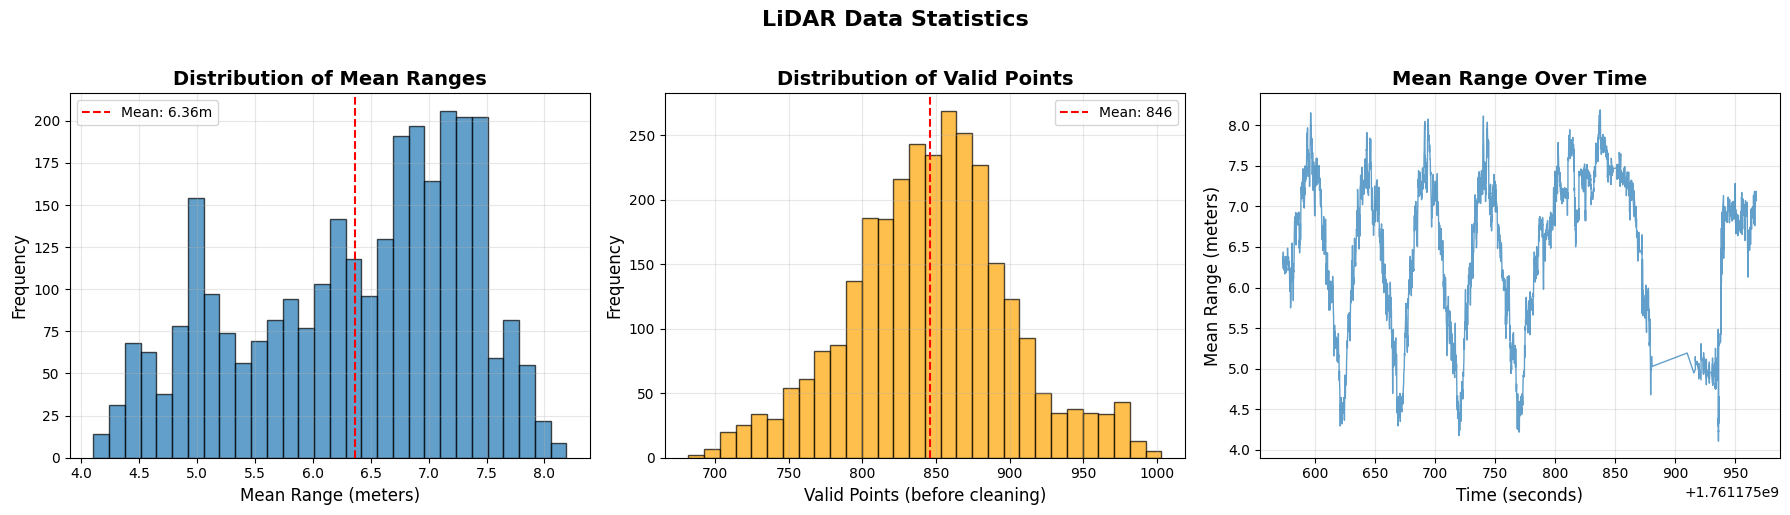

✓ Statistics plot saved: /content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/session_20251022_155137/processed_lidar/lidar_statistics.png


In [22]:
# Distribution analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Mean range distribution
axes[0].hist(df_lidar_metadata['mean_range'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Mean Range (meters)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Mean Ranges', fontsize=14, fontweight='bold')
axes[0].axvline(df_lidar_metadata['mean_range'].mean(), color='r', linestyle='--',
                label=f"Mean: {df_lidar_metadata['mean_range'].mean():.2f}m")
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: Valid points distribution
axes[1].hist(df_lidar_metadata['valid_points'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Valid Points (before cleaning)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Valid Points', fontsize=14, fontweight='bold')
axes[1].axvline(df_lidar_metadata['valid_points'].mean(), color='r', linestyle='--',
                label=f"Mean: {df_lidar_metadata['valid_points'].mean():.0f}")
axes[1].legend()
axes[1].grid(alpha=0.3)

# Plot 3: Scan timeline
axes[2].plot(df_lidar_metadata['timestamp'], df_lidar_metadata['mean_range'],
             linewidth=1, alpha=0.7)
axes[2].set_xlabel('Time (seconds)', fontsize=12)
axes[2].set_ylabel('Mean Range (meters)', fontsize=12)
axes[2].set_title('Mean Range Over Time', fontsize=14, fontweight='bold')
axes[2].grid(alpha=0.3)

plt.suptitle('LiDAR Data Statistics', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(LIDAR_OUTPUT_DIR, 'lidar_statistics.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Statistics plot saved: {os.path.join(LIDAR_OUTPUT_DIR, 'lidar_statistics.png')}")

## <font color='#FF6B35'>10. Final Summary Report</font>

In [23]:
# Generate comprehensive summary report
print("=" * 60)
print("LIDAR PREPROCESSING - FINAL SUMMARY")
print("=" * 60)

summary_report = f"""
{'='*70}
LIDAR PREPROCESSING SUMMARY REPORT
{'='*70}

INPUT:
   Source Bag: {bag_path.name}
   Topic: /scan
   Sensor: RPLIDAR A1

RAW DATA SPECIFICATIONS:
   Points per scan: {int(df_lidar_metadata['original_points'].iloc[0])}
   Angular coverage: {LIDAR_CONFIG['angular_range'][0]}° to {LIDAR_CONFIG['angular_range'][1]}°
   Range: {LIDAR_CONFIG['range_min']:.2f}m - {LIDAR_CONFIG['range_max']:.2f}m
   Valid data rate: {100 * df_lidar_metadata['valid_points'].mean() / df_lidar_metadata['original_points'].iloc[0]:.1f}%

 PREPROCESSING PIPELINE:
   1. Invalid handling: Replace inf/nan with {LIDAR_CONFIG['range_max']}m
   2. Resampling: {int(df_lidar_metadata['original_points'].iloc[0])} → {LIDAR_CONFIG['target_points']} points (linear interpolation)
   3. Normalization: [{LIDAR_CONFIG['range_min']}, {LIDAR_CONFIG['range_max']}]m → [0, 1]
   4. Format: Single-row CSV (no header)

OUTPUT:
   Directory: {LIDAR_OUTPUT_DIR}/
   Total scans: {scan_count}
   File format: scan_NNNNNNN.csv ({LIDAR_CONFIG['target_points']} values each)
   Metadata: metadata.csv (required by next notebook)
   Info: preprocessing_info.json

TEMPORAL STATISTICS:
   Duration: {df_lidar_metadata['timestamp'].max() - df_lidar_metadata['timestamp'].min():.2f} sec
   Scan rate: {scan_count / (df_lidar_metadata['timestamp'].max() - df_lidar_metadata['timestamp'].min()):.2f} Hz
   Mean interval: {np.mean(np.diff(df_lidar_metadata['timestamp'])):.4f} sec
   Max gap: {np.max(np.diff(df_lidar_metadata['timestamp'])):.4f} sec

SPATIAL STATISTICS:
   Mean range: {df_lidar_metadata['mean_range'].mean():.2f} ± {df_lidar_metadata['mean_range'].std():.2f} m
   Min range: {df_lidar_metadata['min_range'].min():.2f} m
   Max range: {df_lidar_metadata['max_range'].max():.2f} m

QUALITY CHECKS:
   File count: {'PASS' if len(csv_files) == scan_count else 'FAIL'}
   File format: {'PASS' if all_valid else 'FAIL'}
   Value range: {'PASS' if all_in_range else 'FAIL'}
   Temporal continuity: {'PASS' if is_monotonic else 'FAIL'}
   Statistical sanity: {'PASS' if is_sane else 'WARNING'}

NEXT STEPS:
   1. Run notebook: the next phase
   2. The notebook will load processed_lidar/ directory
   3. Extract 256D geometric features using 1D CNN
   4. Save to features.h5 for sensor fusion

 IMPORTANT NOTES:
   CSV format is REQUIRED by next notebook (do not convert to NPY)
   Each CSV must have exactly {LIDAR_CONFIG['target_points']} values
   Values must be in [0, 1] range
   metadata.csv must have 'filename' and 'timestamp' columns
   Timestamps will be used for camera-LiDAR alignment (after feature extraction)

{'='*70}
Processing completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
{'='*70}
"""

print(summary_report)

# Save summary report
report_path = os.path.join(LIDAR_OUTPUT_DIR, 'preprocessing_summary.txt')
with open(report_path, 'w') as f:
    f.write(summary_report)

print(f"\n✅ Summary report saved: {report_path}")
print(f"\nLiDAR preprocessing complete! Conforming to expected input for the next phase.")

LIDAR PREPROCESSING - FINAL SUMMARY

LIDAR PREPROCESSING SUMMARY REPORT

INPUT:
   Source Bag: session_data.bag
   Topic: /scan
   Sensor: RPLIDAR A1

RAW DATA SPECIFICATIONS:
   Points per scan: 1147
   Angular coverage: -180° to 180°
   Range: 0.15m - 12.00m
   Valid data rate: 73.8%

 PREPROCESSING PIPELINE:
   1. Invalid handling: Replace inf/nan with 12.0m
   2. Resampling: 1147 → 360 points (linear interpolation)
   3. Normalization: [0.15, 12.0]m → [0, 1]
   4. Format: Single-row CSV (no header)

OUTPUT:
   Directory: /content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/session_20251022_155137/processed_lidar/
   Total scans: 2973
   File format: scan_NNNNNNN.csv (360 values each)
   Metadata: metadata.csv (required by next notebook)
   Info: preprocessing_info.json

TEMPORAL STATISTICS:
   Duration: 394.20 sec
   Scan rate: 7.54 Hz
   Mean interval: 0.1326 sec
   Max gap: 29.2624 sec

SPATIAL STATISTICS:
   Mean range: